# Projet 5 - Segmentez des clients d'un site e-commerce (Partie 2)

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Etudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📊 Partie 2 : Apprentissage non supervisé

Ce notebook explore l’application de l’**apprentissage non supervisé** pour segmenter les clients en groupes homogènes en fonction de leur comportement d'achat (RFM) et de satisfaction (score de satisfaction). Nous testons plusieurs méthodes de clustering afin d'identifier la segmentation la plus pertinente pour l'équipe marketing. Enfin, nous analysons la **stabilité des segments dans le temps** pour recommander une **fréquence optimale de mise à jour du modèle** (dans un 3ème notebook).

<img src="https://user.oc-static.com/upload/2023/03/21/16793895608947_Screenshot%202023-03-21%20at%2010.05.50.png" width="720" />

## ⚡ Mission

Nous sommes **consultant pour Olist** et nous avons été chargé de **réaliser cette segmentation**, en mettant en place des modèles d'**apprentissage non supervisé** et en fournissant un **plan de maintenance** du modèle.

**Segmentation client**

- Explorer et analyser les données fournies.
- Mettre en place une segmentation des clients en utilisant des algorithmes d’apprentissage non supervisé (ex. clustering).
- Fournir une analyse approfondie des segments obtenus pour une exploitation optimale par l'équipe Marketing.
- Proposer un plan de maintenance basé sur une simulation de fréquence de mise à jour du modèle.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from datetime import datetime

In [3]:
# Set display options to show the DataFrame in full width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## Chargement commandes

Nous chargeons les commandes précedemment exportées depuis le notebook `p05-david_scanu_02_notebook_exploration_20250117.ipynb`.


In [4]:
data_dir = './content/data'
processed_orders = pd.read_csv(os.path.join(data_dir, 'processed_orders.csv'))
processed_orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,72.20,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,28.62,5.0


In [5]:
processed_orders.dtypes

order_id                     object
order_purchase_timestamp     object
customer_unique_id           object
payment_value               float64
review_score                float64
dtype: object

## Création des données "client"

Nous créons, à partir des commandes, les **données clients** contenant les colonnes suivantes : 

- `customer_unique_id` : Identifiant unique du client.
- `recency` : Nombre de jours depuis la dernière commande.
- `frequency` : Nombre de commandes passées par le client.
- `monetary` : Montant total dépensé par le client.
- `avg_review_score` : Score moyen des avis laissés par le client.

Nous choisissons l'année `2017` comme période de référence pour effectuer une segmentation de base (baseline). Nous étudierons ensuite l'évolution des clusters en ajoutant des données trimestrielles.

In [6]:
def create_rfm_df(df, start_date = datetime(2017, 1, 1), end_date = datetime(2017, 12, 31, 23, 59, 59), verbose=True):
    """
    Fonction pour créer les colonnes RFM (Récence, Fréquence, Montant) et score de satisfaction à partir des commandes.

    Args:
    - df (pd.DataFrame): Le DataFrame contenant les commandes.

    Returns:
    - pd.DataFrame: Le DataFrame contenant les colonnes RFM et score de satisfaction.
    """
    # Convertir la colonne 'order_purchase_timestamp' au format datetime
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    # Filtrer les commandes pour la période spécifiée
    df = df[(df['order_purchase_timestamp'] >= start_date) & (df['order_purchase_timestamp'] <= end_date)]

    if verbose:
        print("Nombre de commandes : ", df.shape[0])
        print("Nombre de clients uniques :", df['customer_unique_id'].nunique())
        print("Période : ", start_date, " à ", end_date)
        print("Date de la première commande :", df['order_purchase_timestamp'].min())
        print("Date de la dernière commande :", df['order_purchase_timestamp'].max())
        print()

    # Si des commandes existents
    if not df.empty:

        # Créer une table pivot pour RFM
        rfm_df = df.pivot_table(
            index='customer_unique_id',
            values='order_purchase_timestamp',
            aggfunc={'order_purchase_timestamp': 'max'}
        )

        rfm_df.rename(columns={'order_purchase_timestamp': 'most_recent_purchase'}, inplace=True)

        period_end_timestamp = pd.Timestamp(end_date)

        rfm_df['recency'] = (period_end_timestamp - rfm_df['most_recent_purchase']).dt.days
        rfm_df['frequency'] = df.groupby('customer_unique_id').size()
        rfm_df['monetary'] = df.groupby('customer_unique_id')['payment_value'].sum()
        rfm_df['avg_review_score'] = df.groupby('customer_unique_id')['review_score'].mean().round()

        rfm_df = rfm_df.drop(columns='most_recent_purchase')

        return rfm_df

    else:
        print(f"Aucune commandes trouvées pour la période : {start_date} à {end_date}")
        return None

### Données client pour l'année 2017

In [7]:
rfm_baseline = create_rfm_df(processed_orders)
print("Données RFM+S :", rfm_baseline.shape)
print(rfm_baseline.head(10))

Nombre de commandes :  43100
Nombre de clients uniques : 41824
Période :  2017-01-01 00:00:00  à  2017-12-31 23:59:59
Date de la première commande : 2017-01-05 11:56:06
Date de la dernière commande : 2017-12-31 23:29:31

Données RFM+S : (41824, 4)
                                  recency  frequency  monetary  avg_review_score
customer_unique_id                                                              
0000f46a3911fa3c0805444483337064      296          1     86.22               3.0
0000f6ccb0745a6a4b88665a16c9f078       80          1     43.62               4.0
0004aac84e0df4da2b147fca70cf8255       47          1    196.89               5.0
0005e1862207bf6ccc02e4228effd9a0      302          1    150.12               4.0
0006fdc98a402fceb4eb0ee528f6a8d4      166          1     29.00               3.0
00082cbe03e478190aadbea78542e933       42          1    126.26               5.0
000a5ad9c4601d2bbdd9ed765d5213b3      142          1     91.28               4.0
000bfa1d2f1a41876493be6

Nous vérifions que nos données RFM+S ne contiennent pas de valeurs manquantes.

In [8]:
missing_values = rfm_baseline.isnull().sum()
print(missing_values)

recency             0
frequency           0
monetary            0
avg_review_score    0
dtype: int64


## Prétraitement variables

In [9]:
from sklearn.preprocessing import StandardScaler

# Preprocessing: scale features
features = ['recency', 'frequency', 'monetary', 'avg_review_score']
scaler = StandardScaler()
X_baseline = scaler.fit_transform(rfm_baseline[features])
print(X_baseline.shape)

(41824, 4)


## Clustering non supervisé

### ⚖️ **L’équilibre entre trop de clusters et pas assez**  

Lorsque l'on choisit le nombre de clusters (*k*) dans un algorithme de clustering comme K-Means, il faut trouver un équilibre entre **sous-segmentation** (pas assez de clusters) et **sur-segmentation** (trop de clusters).  

#### 🔴 **Pas assez de clusters (k trop petit)**  

- Les groupes sont trop larges et hétérogènes.  
- Perte d’informations : des clients aux comportements différents sont regroupés ensemble.  
- La segmentation devient peu exploitable pour le marketing ou la prise de décision.  

#### 🟢 **Nombre optimal de clusters (bon équilibre)**  

- Les groupes sont homogènes et exploitables.  
- La segmentation est claire et utile pour l’entreprise.  
- Les différences entre segments sont significatives.  

#### 🔵 **Trop de clusters (k trop grand)**  

- Chaque cluster devient très petit et spécifique.  
- Risque de sur-ajustement (*overfitting*) : la segmentation ne généralise pas bien.  
- Complexité inutile : difficile à interpréter et à utiliser en pratique.  

### 🎯 **Comment trouver le bon équilibre ?**  

Le choix du nombre optimal de clusters (*k*) est crucial pour obtenir une segmentation pertinente. Plusieurs méthodes peuvent être utilisées pour déterminer la meilleure valeur de *k*, parmi lesquelles :

- Utiliser la **méthode du coude** pour identifier un point où l'inertie n’évolue plus significativement.  
- Vérifier le **coefficient de silhouette** pour maximiser la séparation entre clusters.  
- Prendre en compte la **faisabilité métier** : un trop grand nombre de segments peut être inutilisable pour une équipe marketing.  

L’objectif est d’avoir **suffisamment de clusters pour capturer les comportements distincts, mais pas trop pour garder une segmentation exploitable.**

### La méthode du coude (*Elbow Method*)

La **méthode du coude** est une approche couramment utilisée pour déterminer le nombre optimal de clusters dans un algorithme K-Means. Elle repose sur l’analyse de l’**inertie intra-cluster** (somme des distances des points à leur centre de cluster).  

On trace cette inertie en fonction du nombre de clusters (*k*). Initialement, l’inertie diminue fortement, mais au-delà d’un certain *k*, la réduction devient marginale, formant un **point de coude** sur la courbe. Ce point correspond au nombre optimal de clusters, car il équilibre précision et simplicité du modèle.  

Bien que cette méthode soit efficace, elle doit être complétée par d’autres indicateurs comme le **coefficient de silhouette** pour confirmer la pertinence du choix de *k*. 🚀

*Remarque* : Within-Cluster Sum of Squares (WCSS), Sum of Squared Distances (SSD) et inertie intra-cluster sont synonymes et servent à évaluer la cohésion des clusters.

**Documentation**

- https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [ ]:
from sklearn.cluster import KMeans

def calculate_ssd(data, k_max=20):
  """
  Calcule la somme des distances au carré pour différents nombres de clusters
  """
  # Calculer la somme des distances au carré pour différents nombres de clusters
  ssd = {}
  for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300, tol=1e-4)
    kmeans.fit(data)
    ssd[k] = kmeans.inertia_
  return ssd

ssd = calculate_ssd(X_baseline)

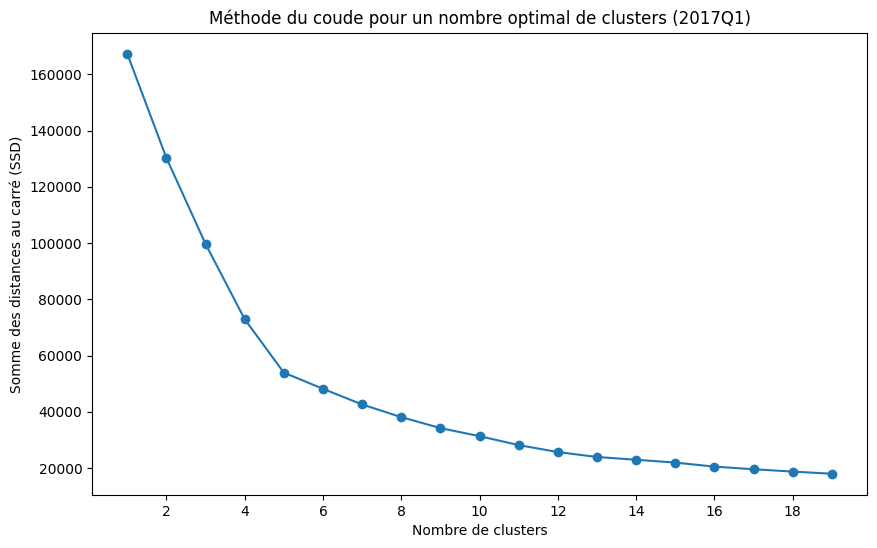

In [ ]:
# Tracer le SSE pour chaque nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(list(ssd.keys()), list(ssd.values()), marker='o')
plt.title('Méthode du coude pour un nombre optimal de clusters (2017Q1)')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des distances au carré (SSD)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

La **méthode du coude** semble indiquer que le nombre optimal de clusters est de **5**.

### Le coefficient de silhouette (*Silhouette Score*) :  

- Cette métrique évalue la cohésion interne des clusters en mesurant à quel point chaque point est bien regroupé avec ses voisins.  
- Il est compris entre -1 et 1 :
  - **Proche de 1** : L’individu est bien assigné à son cluster.
  - **Proche de 0** : L’individu est à la frontière entre deux clusters.
  - **Proche de -1** : L’individu serait mieux placé dans un autre cluster.  
- On teste plusieurs valeurs de *k* et on choisit celle qui maximise le score de silhouette.  

Le **coefficient de silhouette** (*Silhouette Score*) doit être **élevé** pour indiquer un bon clustering.  

**Interprétation du coefficient de silhouette**  

Le *Silhouette Score* mesure la **qualité du regroupement des clusters** en évaluant à la fois :  
- **La cohésion intra-cluster** : à quel point un point est proche des autres points de son cluster.  
- **La séparation inter-cluster** : à quel point un point est éloigné des clusters voisins.  

### 🎯 **Interprétation des valeurs de silhouette**  
- **\( S \) proche de 1** → Segmentation bien définie (les points sont bien regroupés et bien séparés). ✅  
- **\( S \) proche de 0** → Les clusters se chevauchent, mauvaise séparation. ⚠️  
- **\( S \) négatif** → Mauvais clustering (les points sont plus proches d'un autre cluster que du leur). ❌  

In [ ]:
%%time

from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(data, k_max=20):
  """
  Calcule les scores de silhouette pour différents nombres de clusters

  Args: 
  - data: les données à utiliser pour le clustering.
  - range_n_clusters: une liste de nombres de clusters à tester.

  Returns:
  - silhouette_scores: un dictionnaire contenant les scores de silhouette pour chaque nombre de clusters.
  """
  # Dictionnaire pour stocker les scores de silhouette
  silhouette_scores = {}
  # Itérer sur la plage de clusters
  for n_clusters in list(range(2, k_max)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300, tol=1e-4)
    cluster_labels = kmeans.fit_predict(data)
    # Calculer le score de silhouette
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores[n_clusters] = silhouette_avg
    print(f"Pour n_clusters = {n_clusters}, le score de silhouette moyen est {silhouette_avg:.4f}")
  return silhouette_scores

# silhouette_scores = calculate_silhouette_scores(X_baseline)

Pour n_clusters = 2, le score de silhouette moyen est 0.6818
Pour n_clusters = 3, le score de silhouette moyen est 0.3372
Pour n_clusters = 4, le score de silhouette moyen est 0.4040
Pour n_clusters = 5, le score de silhouette moyen est 0.4262
Pour n_clusters = 6, le score de silhouette moyen est 0.4338
Pour n_clusters = 7, le score de silhouette moyen est 0.4324
Pour n_clusters = 8, le score de silhouette moyen est 0.3615
Pour n_clusters = 9, le score de silhouette moyen est 0.3632
Pour n_clusters = 10, le score de silhouette moyen est 0.3664
Pour n_clusters = 11, le score de silhouette moyen est 0.3797
Pour n_clusters = 12, le score de silhouette moyen est 0.3803
Pour n_clusters = 13, le score de silhouette moyen est 0.3848
Pour n_clusters = 14, le score de silhouette moyen est 0.3612
Pour n_clusters = 15, le score de silhouette moyen est 0.3747
Pour n_clusters = 16, le score de silhouette moyen est 0.3787
Pour n_clusters = 17, le score de silhouette moyen est 0.3788
Pour n_clusters 

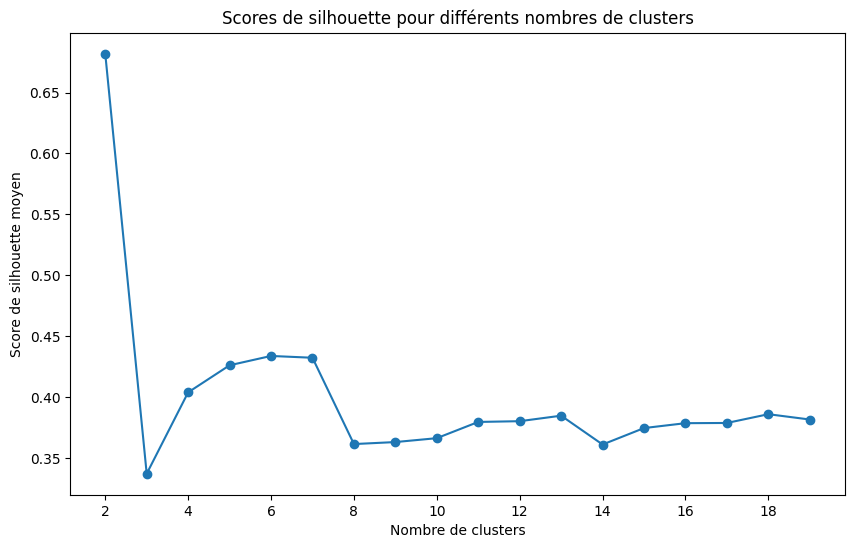

In [ ]:

def display_silhouette_scores(silhouette_scores):
    """
    Affiche les scores de silhouette pour différents nombres de clusters

    Args:
    - silhouette_scores: un dictionnaire contenant les scores de silhouette pour chaque nombre de clusters.
    """
    # Tracer les scores de silhouette
    plt.figure(figsize=(10, 6))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.title('Scores de silhouette pour différents nombres de clusters')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette moyen')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# Tracer les scores de silhouette
# display_silhouette_scores(silhouette_scores)

**Comment interpréter cette tendance ?**  
- Le **score optimal est généralement atteint pour un \( k \) qui équilibre bien séparation et cohésion**.  
- Ici, \( k = 2 \) a le meilleur score, mais cela peut être trop peu pour une segmentation utile.  
- Il faut trouver **un compromis entre score de silhouette et pertinence métier**.  

**Que faire ensuite ?**  

- **Examiner les clusters visuellement** (via PCA ou t-SNE) pour vérifier s’ils sont pertinents.  
- **Croiser avec d'autres critères** comme la méthode du coude (inertie intra-cluster).  
- **Prendre en compte l'objectif métier** pour choisir un \( k \) optimal.  


### Nombre de clusters choisis : 6

Nous choisissons **6 clusters** pour la segmentation RFM des clients en me basant sur l'analyse de la **méthode du coude** et du **score de silhouette**. Le score de silhouette a montré une meilleure cohésion et séparation des clusters autour de 5 et 6 clusters, avec un léger avantage pour 6. De plus, la méthode du coude a révélé une cassure (peu marquée) à 5 clusters, suggérant que c'était un bon compromis entre une segmentation fine et une structure claire des données. Ce choix permet ainsi une segmentation efficace et bien définie des clients.

Nous calculons le clustering pour 6 clusters avec la méthode `KMeans`, pour chaque trimestre. 

In [11]:
%%time
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Train k-means on baseline data
k = 6  # or choose via domain knowledge / elbow method
kmeans_baseline = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm_baseline['cluster'] = kmeans_baseline.fit_predict(X_baseline)


# Save the baseline model parameters: scaler and cluster centers
baseline_centers = kmeans_baseline.cluster_centers_

CPU times: user 5.55 s, sys: 50.1 ms, total: 5.6 s
Wall time: 787 ms


## Analyse et interprétation

Nous cherchons à comprendre les clusters obtenus à travers les étapes suivante :

- Visualisation des clusters ajoutés à nos données (colonne `cluster`)
- Visualisation de la distribution des clusters
- Indices de qualité des clusters : Utilisation des métriques pour évaluer la cohérence des clusters.
  - **silhouette score**
  - **Indice de Davies-Bouldin (DBI)** : Évalue la séparation et la compacité des clusters.
  - **Indice de Calinski-Harabasz** : Compare la variance inter-cluster et intra-cluster.
- Visualisation des clusters : graphiques 2D ou 3D (e.g., PCA ou t-SNE) pour visualiser la segmentation.
- Anlayse et interprétation des segments :
  - Identification des caractéristiques dominantes de chaque cluster : Moyennes, médianes, écarts-types des variables pour chaque cluster.
  - Identification des segments clés : bons clients, clients à risque, etc.
  - Collaboration avec les experts métier pour valider que les segments obtenus sont actionnables et ont une signification pertinente.

### Visualisation des clusters ajoutés

In [12]:
rfm_baseline.head()

,recency,frequency,monetary,avg_review_score,cluster
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,0
0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,3
0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,3
0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,0
0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,4


### Visualisation de la distribution des clusters

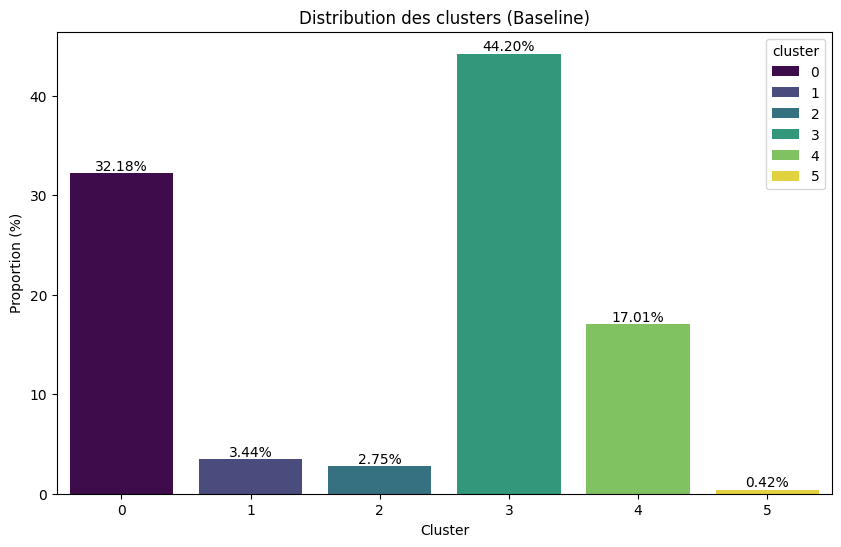

In [43]:
baseline_distribution = rfm_baseline['cluster'].value_counts(normalize=True).sort_index()

# Visualiser la distribution des clusters (baseline)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=baseline_distribution.index, y=baseline_distribution.values * 100, hue=baseline_distribution.index, palette='viridis')
plt.title('Distribution des clusters (Baseline)')
plt.xlabel('Cluster')
plt.ylabel('Proportion (%)')

# Ajouter les valeurs en pourcentage au-dessus de chaque barre
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.2f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.show()

### Indices de qualité des clusters

In [13]:
# Compute baseline quality metrics
baseline_inertia = kmeans_baseline.inertia_
baseline_silhouette = silhouette_score(X_baseline, rfm_baseline['cluster'])
baseline_dbi = davies_bouldin_score(X_baseline, rfm_baseline['cluster'])
baseline_chi = calinski_harabasz_score(X_baseline, rfm_baseline['cluster'])


print("\nBaseline Clustering Metrics:")
print("Inertia:", baseline_inertia)
print("Silhouette Score:", baseline_silhouette)
print("Davies-Bouldin Index (DBI):", baseline_dbi)
print("Calinski-Harabasz Index (CHI):", baseline_chi)


Baseline Clustering Metrics:
Inertia: 48194.906329632075
Silhouette Score: 0.43383438446471073
Davies-Bouldin Index (DBI): 0.761749120005253
Calinski-Harabasz Index (CHI): 20668.449098572102


L’interprétation des métriques de clustering obtenues permet d’évaluer la qualité des segments créés par **K-Means** :

#### Inertie : 48194.91
- L'inertie mesure la **compacité des clusters** : plus elle est faible, plus les points sont proches de leur centroïde.  
- Ici, une valeur élevée signifie que les clusters sont assez dispersés. Toutefois, l’inertie **diminue toujours quand on augmente \( k \)**, donc il faut la comparer avec d'autres valeurs et ne pas l’utiliser seule.

#### Silhouette Score : 0.43
- Il varie entre **-1 et 1** :
  - **Proche de 1** → les clusters sont bien séparés et compacts.
  - **Autour de 0** → les points sont à la frontière entre clusters.
  - **Négatif** → certains points sont mal assignés.  
- **0.43** est **modéré**, ce qui suggère que les clusters sont assez bien définis mais peuvent être améliorés.

#### Davies-Bouldin Index (DBI) : 0.76  
- **Plus il est faible, mieux c’est** : cela indique que les clusters sont bien séparés et compacts.  
- Une valeur **inférieure à 1** est généralement **bonne**.
- Ici, **0.76** est un bon score, suggérant que les clusters ne sont pas trop proches les uns des autres.

#### Calinski-Harabasz Index (CHI) : 20668.45
- Plus il est **élevé**, mieux c’est : il indique que la variance inter-cluster est forte et que la variance intra-cluster est faible.  
- **20668** est une valeur élevée, ce qui signifie que les clusters sont bien séparés.

#### Interprétation globale

**Le clustering semble globalement cohérent** :  
- Les clusters sont **relativement bien définis** (**Silhouette = 0.43**).  
- **Bonne séparation entre clusters** (**DBI = 0.76** et **CHI élevé**).  
- L'inertie est **élevée**, mais ce n'est pas un problème si les autres métriques sont bonnes.

#### Axes d’amélioration possibles :  
- **Tester d'autres valeurs de \( k \)** (ex. 4 ou 7) pour voir si l’inertie et le Silhouette Score s’améliorent.  
- **Essayer une autre méthode de clustering** (ex. DBSCAN ou Agglomerative) pour voir si une meilleure structure apparaît.  
- **Standardiser ou normaliser les données différemment** pour s’assurer que certaines variables ne dominent pas les autres.

### Visualisation des clusters : TSNE

Le t-SNE (t-Distributed Stochastic Neighbor Embedding) est une méthode non supervisée de réduction de dimension qui projette des données complexes dans un espace 2D ou 3D tout en préservant les relations de proximité entre les points, facilitant leur visualisation. Le t-SNE vise à :

- Projeter des données multi-dimensionnelles dans un espace à faible dimension (souvent 2D ou 3D), tout en préservant les relations locales (c'est-à-dire les similarités entre les points proches dans l'espace d'origine).
- Faciliter la visualisation des données complexes, notamment lorsqu'elles contiennent des structures non linéaires difficiles à capturer par des techniques linéaires comme la PCA.

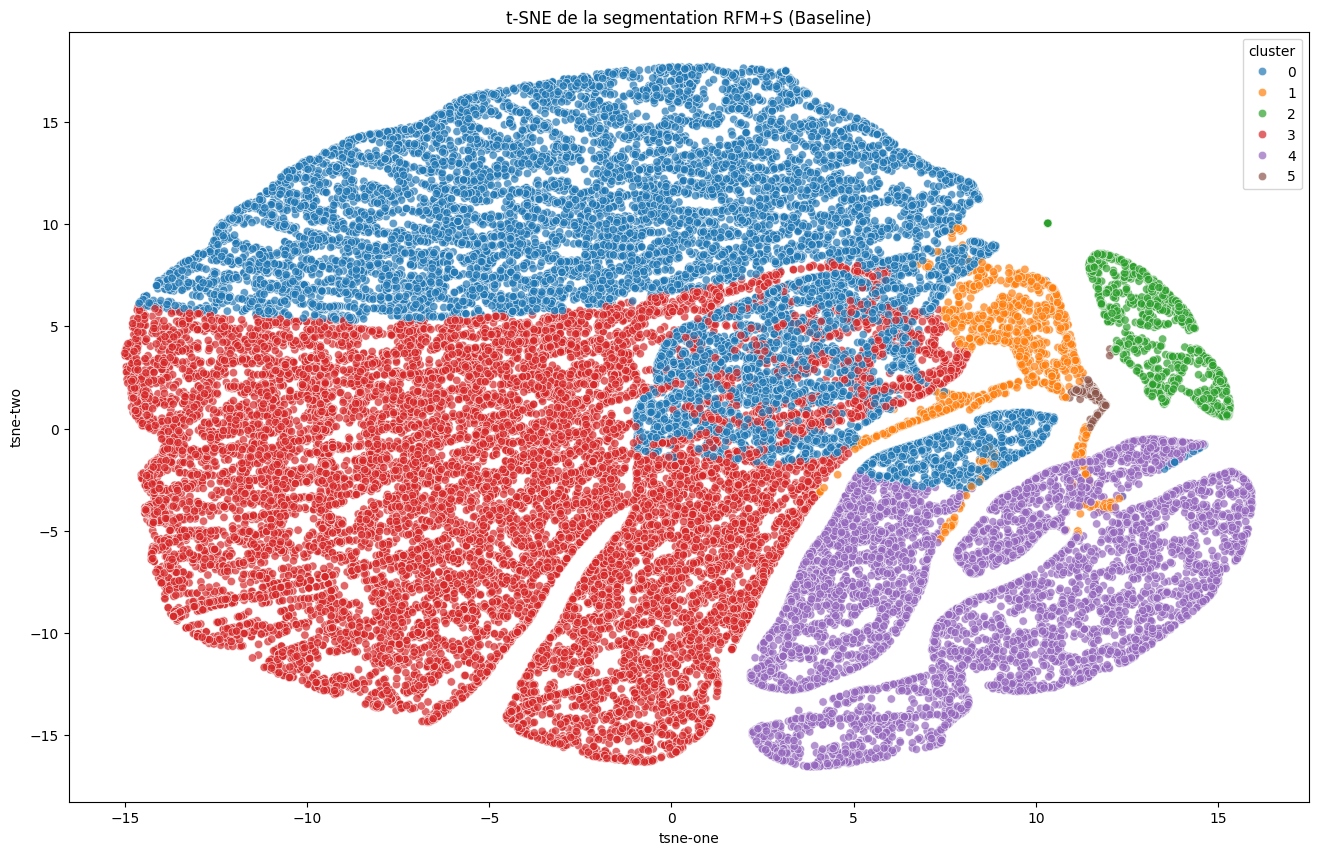

CPU times: user 3min 4s, sys: 988 ms, total: 3min 5s
Wall time: 1min 2s


In [ ]:
%%time
from sklearn.manifold import TSNE

def display_tsne(rfm_data, rfm_data_scaled):
    """
    Réduit les dimensions des données à l'aide de t-SNE et affiche les clusters.

    Args:
    - rfm_data: le DataFrame original contenant les données RFM.
    - rfm_data_scaled: les données RFM standardisées sous forme de ndarray.

    Returns:
    - None
    """
    # Convertir rfm_data_scaled en DataFrame pour conserver les index
    rfm_data_scaled_df = pd.DataFrame(rfm_data_scaled, index=rfm_data.index)

    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(rfm_data_scaled_df)

    # Créer un DataFrame pour stocker les résultats de t-SNE
    tsne_df = pd.DataFrame(tsne_results, columns=['tsne-one', 'tsne-two'], index=rfm_data.index)

    # Ajouter les étiquettes de cluster
    tsne_df['cluster'] = rfm_data['cluster']

    # Tracer le t-SNE
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue="cluster",
        palette=sns.color_palette("tab10", len(tsne_df['cluster'].unique())),
        data=tsne_df,
        legend="full",
        alpha=0.7
    )
    plt.title('t-SNE de la segmentation RFM+S (Baseline)')
    plt.show()

# Appel de la fonction
display_tsne(rfm_baseline, X_baseline)

**Interprétation** 

- Si les clusters sont bien séparés dans l’espace t-SNE, cela confirme que votre segmentation capture bien des regroupements naturels.
- Si les clusters se mélangent beaucoup, cela peut indiquer que votre segmentation a besoin d'être affinée.



### Analyse en Composantes Principales (PCA)

La PCA est une méthode de réduction de dimension qui transforme les données en un espace de variables non corrélées appelées composantes principales.
Les premières composantes principales capturent la majorité de la variance dans les données, permettant une visualisation simplifiée en 2D tout en conservant l'essentiel de l'information.

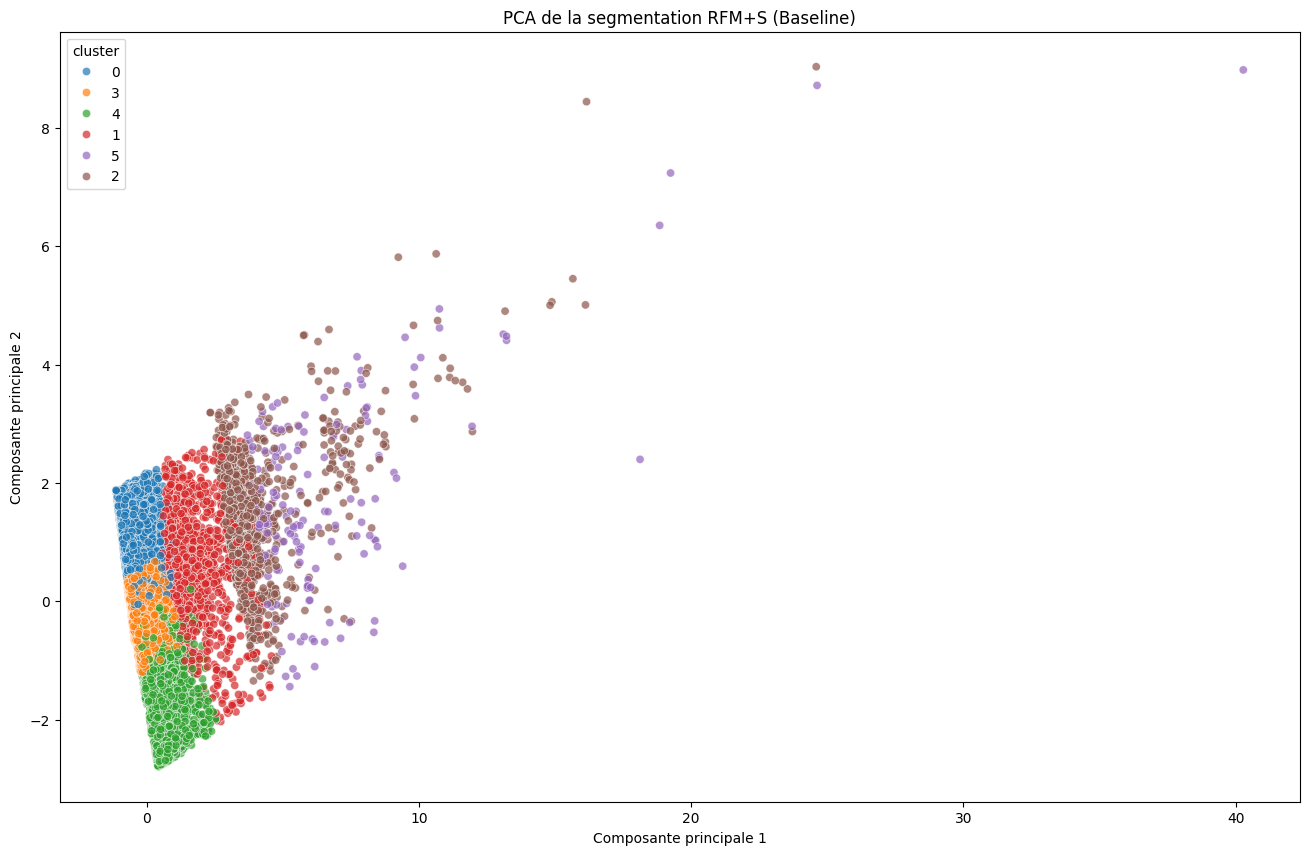

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def display_pca(data, labels, title='PCA of Clusters'):
    """
    Réduit les dimensions des données à l'aide de PCA et affiche les clusters.

    Args:
    - data: ndarray, les données standardisées.
    - labels: Series ou ndarray, les étiquettes de clusters (doivent être alignées).
    - title: str, le titre du graphique.

    Returns:
    - None
    """
    # Réduction de dimension avec PCA
    pca = PCA(n_components=2, random_state=42)
    pca_results = pca.fit_transform(data)

    # Vérifier si labels est une pandas Series et réaligner avec X_baseline
    labels = pd.Series(labels).reset_index(drop=True)  

    # Créer un DataFrame pour stocker les résultats de PCA
    pca_df = pd.DataFrame(pca_results, columns=['PCA1', 'PCA2'])

    # Ajouter les clusters et convertir en string pour l'affichage
    pca_df['cluster'] = labels.astype(str)

    # Tracer le PCA
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x="PCA1", y="PCA2",
        hue="cluster",
        palette=sns.color_palette("tab10", len(pca_df['cluster'].unique())),
        data=pca_df,
        legend="full",
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.show()

# Aligner les labels et appeler la fonction
display_pca(X_baseline, rfm_baseline['cluster'].values, title='PCA de la segmentation RFM+S (Baseline)')


**Interprétation**

Chaque point représente **un client (coloré selon son cluster)**.

Les clusters dans l'espace des deux premières composantes principales permettent de visualiser les regroupements basés sur les dimensions RFM.
La dispersion et les chevauchements entre clusters reflètent la variabilité des caractéristiques RFM et l'efficacité de la segmentation.

### Moyenne des variables R, F, M, et satisfaction par cluster.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_cluster_profiles_viz(cluster_means: pd.DataFrame, title: str):
    """
    Fonction pour afficher les profils de cluster sous forme de graphiques à barres.

    Args:
    - cluster_means: un DataFrame contenant les moyennes des variables par cluster.

    Returns:
    - None
    """

    # Initialise la fonction subplot en utilisant le nombre de lignes et de colonnes
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Ajouter un titre global pour les sous-graphiques
    fig.suptitle(title, fontsize=16)

    # Fonction pour ajouter des étiquettes de valeur au-dessus des barres
    def add_value_labels(ax):
            for p in ax.patches:
                    if p.get_height() > 0:  # Avoid annotating legend elements
                            ax.annotate(f'{p.get_height():.2f}', 
                                                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                                                    ha='center', va='bottom', fontsize=10, color='black')

    # Récence par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['recency'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[0, 0])
    axes[0, 0].set_title('Récence')
    axes[0, 0].set_xlabel('Cluster')
    axes[0, 0].set_ylabel('Récence')
    add_value_labels(ax)

    # Fréquence par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['frequency'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[0, 1])
    axes[0, 1].set_title('Fréquence')
    axes[0, 1].set_xlabel('Cluster')
    axes[0, 1].set_ylabel('Fréquence')
    add_value_labels(ax)

    # Valeur monétaire par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['monetary'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[1, 0])
    axes[1, 0].set_title('Valeur monétaire')
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Valeur monétaire')
    add_value_labels(ax)

    # Score moyen des avis par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['avg_review_score'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[1, 1])
    axes[1, 1].set_title('Score moyen des avis')
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel('Score moyen des avis')
    add_value_labels(ax)

    # Ajuster la disposition pour un meilleur espacement
    plt.tight_layout()
    plt.show()

Nous affichons les **moyennes des variables RFM+S** pour chaque cluster, sous forme de diagramme en barres,  pour le trimestre '2017Q1'.

            recency  frequency     monetary  avg_review_score
cluster                                                      
0        240.183075   1.000000   124.700612          4.605320
1        137.712500   1.000000   808.865437          4.340972
2        123.582245   2.101828   281.937911          4.175805
3         71.311388   1.000000   123.374195          4.745145
4        111.176925   1.000000   140.946845          1.835722
5        154.788571   1.057143  2323.280743          3.800000


/tmp/ipykernel_13769/1668382489.py:30: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=cluster_means.index, y=cluster_means['recency'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[0, 0])
/tmp/ipykernel_13769/1668382489.py:37: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=cluster_means.index, y=cluster_means['frequency'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[0, 1])
/tmp/ipykernel_13769/1668382489.py:44: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=cluster_means.index, y=cluster_means['monetary'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[1, 0])
/tmp/ipykernel_13769/1668382489.py:51: UserWarning: 

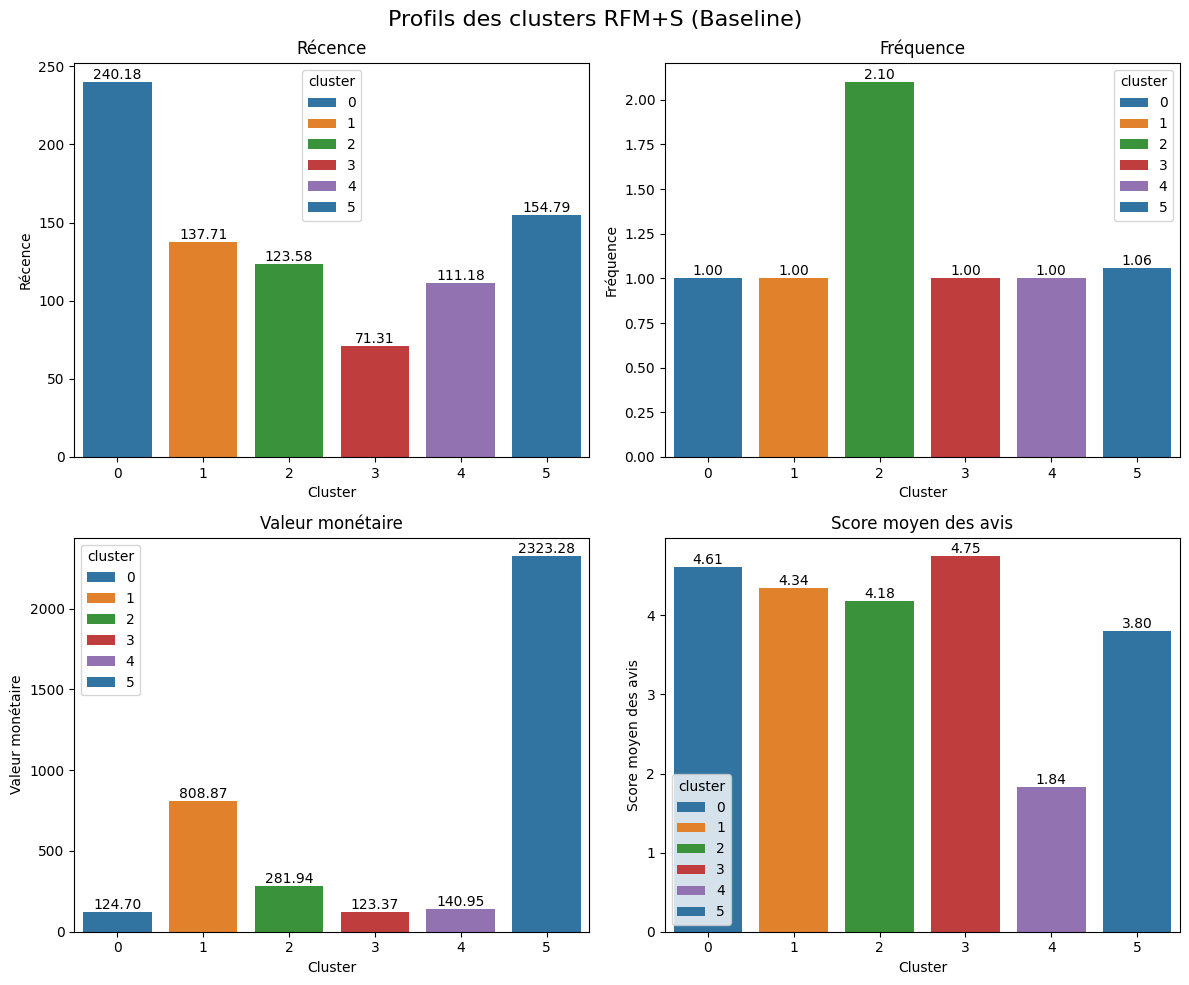

In [15]:
# Calculer la moyenne des variables par cluster
cluster_means = rfm_baseline.groupby('cluster').mean()
print(cluster_means[['recency', 'frequency', 'monetary', 'avg_review_score']])
display_cluster_profiles_viz(cluster_means, 'Profils des clusters RFM+S (Baseline)')

### Interprétation et stratégie pour chaque cluster

#### **Cluster 0**
- **Interprétation :**  

- **Stratégie :**  


#### **Cluster 1**
- **Interprétation :**  

- **Stratégie :**  


#### **Cluster 2**
- **Interprétation :**  

- **Stratégie :**  
  


> Après interprétation, si deux classes sont très rapprochées, nous pouvons les réunir et diminuer le nombre de clusters (k).

## Stabilité des segments dans le temps

Nous analysons la **stabilité des segments dans le temps** pour recommander une **fréquence optimale de mise à jour du modèle** (dans un 3ème notebook).

Analyse de la variation d'un indicateur en fonction de la segmentation sur différentes périodes sur différentes périodes. 

### Évaluer la stabilité des clusters

Comparez les clusters entre différentes périodes pour analyser leur cohérence. Les approches courantes incluent :

- Indice de Rand ajusté (ARI) : Compare les étiquettes des clusters entre deux périodes pour mesurer leur similarité.
- Homogénéité et Complétude : Mesure si les points d'un même cluster restent regroupés dans les périodes suivantes.
- Distance des centres de clusters : Comparez les positions des centres de clusters pour voir s'ils se déplacent significativement.

*Attention* : Nous n'avons que 3 trimestres pour l'année 2018. 

In [39]:
processed_orders['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [40]:
# 3 premiers trimestres de 2018
monitor_dates = [datetime(2018, 3, 31, 23, 59, 59), datetime(2018, 6, 30, 23, 59, 59), datetime(2018, 9, 30, 23, 59, 59)]

In [41]:
%%time
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from scipy.stats import ks_2samp

print("\nBaseline Clustering Metrics:")
print("Inertia:", baseline_inertia)
print("Silhouette Score:", baseline_silhouette)
print("Cluster Distribution:\n", baseline_distribution)

print("\n--- Monitoring for Drift ---")

for monitor_date in monitor_dates:
    print(f"\n--- Monitoring at period end: {monitor_date.date()} ---")
    # Aggregate new RFM data for current period
    rfm_new = create_rfm_df(processed_orders, end_date=monitor_date)
    
    # Align customers: use intersection of baseline and new customers for label-based comparisons
    common_customers = rfm_baseline.index.intersection(rfm_new.index)
    # print("Common Customers:", len(common_customers))
    rfm_new = rfm_new.loc[common_customers]
    # print("New RFM Shape (after alignment):", rfm_new.shape)
    X_new = scaler.transform(rfm_new[features])
    
    # Option 1: Use the baseline k-means model to assign clusters (keeps the original segmentation)
    rfm_new['cluster_baseline'] = kmeans_baseline.predict(X_new)
    
    # Option 2: Retrain a k-means on new data (to see the drift in cluster centers) 
    # Note: In production, you might not retrain until you decide to update.
    kmeans_new = KMeans(n_clusters=k, random_state=42, n_init=10)
    rfm_new['cluster_new'] = kmeans_new.fit_predict(X_new)
    
    new_inertia = kmeans_new.inertia_
    new_silhouette = silhouette_score(X_new, rfm_new['cluster_new'])
    new_distribution = rfm_new['cluster_new'].value_counts(normalize=True).sort_index()
    
    print("New Data Metrics:")
    print("Inertia:", new_inertia)
    print("Silhouette Score:", new_silhouette)
    print("Cluster Distribution:\n", new_distribution)
    
    # Compare baseline vs. new clustering (only on common customers)
    ari = adjusted_rand_score(rfm_baseline.loc[common_customers, 'cluster'], rfm_new['cluster_new'])
    homogeneity = homogeneity_score(rfm_baseline.loc[common_customers, 'cluster'], rfm_new['cluster_new'])
    completeness = completeness_score(rfm_baseline.loc[common_customers, 'cluster'], rfm_new['cluster_new'])
    
    print("Adjusted Rand Index (ARI):", ari)
    print("Homogeneity:", homogeneity)
    print("Completeness:", completeness)
    
    # Compare feature distributions using KS test
    for feature in features:
        stat, p_value = ks_2samp(rfm_baseline.loc[common_customers, feature],
                                  rfm_new[feature])
        print(f"KS test for {feature}: statistic={stat:.3f}, p-value={p_value:.3f}")
    
    # Compare cluster centers distance
    centers_new = kmeans_new.cluster_centers_
    # Calculate Euclidean distances between baseline and new cluster centers
    from scipy.spatial.distance import cdist
    distance_matrix = cdist(baseline_centers, centers_new, metric='euclidean')
    print("Distance Matrix between Baseline and New Cluster Centers:")
    print(distance_matrix)
    
    # Decide if drift is significant: you might define thresholds based on business rules or historical data.
    inertia_change = abs(new_inertia - baseline_inertia) / baseline_inertia
    silhouette_change = abs(new_silhouette - baseline_silhouette) / baseline_silhouette
    if inertia_change > 0.2 or silhouette_change > 0.2:
        print("Significant change in cluster quality detected. Consider re-training the model.")
    else:
        print("No significant drift detected yet.")
    print("Inertia Change:", inertia_change)
    print("Silhouette Change:", silhouette_change)
    print('---')



Baseline Clustering Metrics:
Inertia: 48194.90632963208
Silhouette Score: 0.43383438446471073
Cluster Distribution:
 cluster
0    0.321801
1    0.034430
2    0.027472
3    0.441971
4    0.170142
5    0.004184
Name: proportion, dtype: float64

--- Monitoring for Drift ---

--- Monitoring at period end: 2018-03-31 ---
Nombre de commandes :  63568
Nombre de clients uniques : 61587
Période :  2017-01-01 00:00:00  à  2018-03-31 23:59:59
Date de la première commande : 2017-01-05 11:56:06
Date de la dernière commande : 2018-03-31 23:54:10

New Data Metrics:
Inertia: 52774.48876980843
Silhouette Score: 0.42819611254289525
Cluster Distribution:
 cluster_new
0    0.448618
1    0.171648
2    0.019534
3    0.003060
4    0.030581
5    0.326559
Name: proportion, dtype: float64
Adjusted Rand Index (ARI): 0.952078962120619
Homogeneity: 0.8943351717526228
Completeness: 0.9204813510550629
KS test for recency: statistic=0.393, p-value=0.000
KS test for frequency: statistic=0.006, p-value=0.407
KS test f

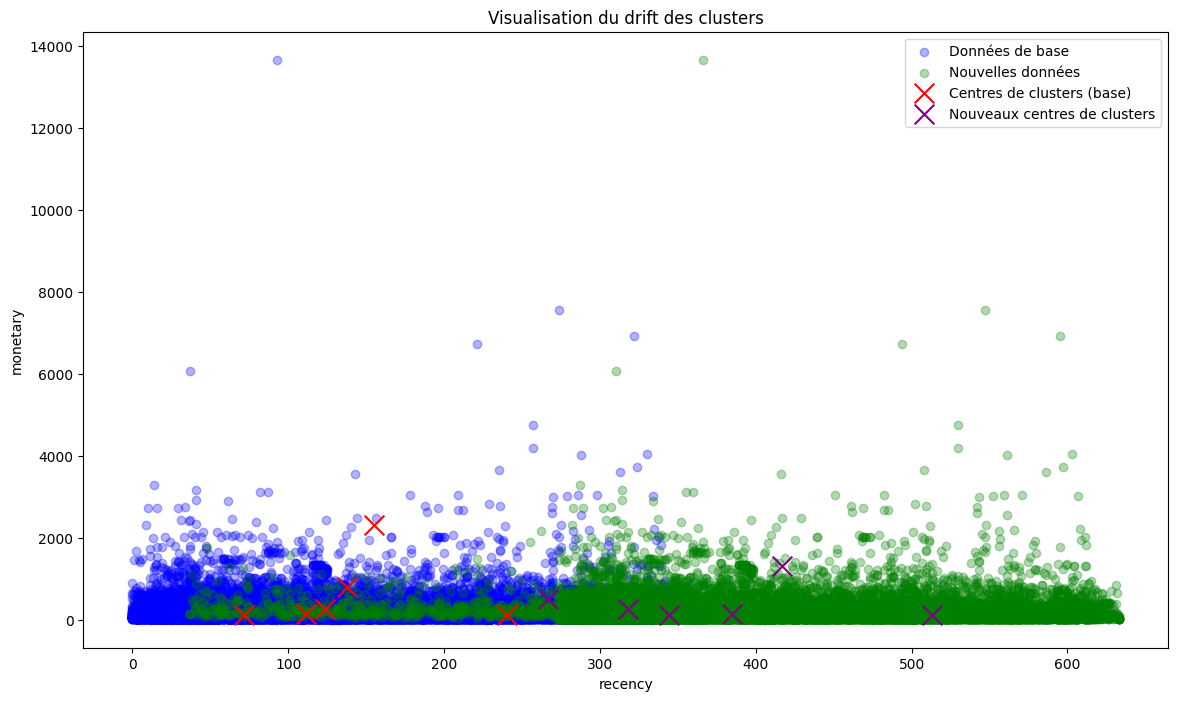

CPU times: user 6.26 s, sys: 67 ms, total: 6.33 s
Wall time: 1.91 s


In [42]:
%%time
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from scipy.stats import ks_2samp

def display_drift(rfm_baseline, processed_orders, end_date, feature_1='recency', feature_2='monetary'):

    rfm_new = create_rfm_df(processed_orders, end_date=end_date, verbose=False)
    
    # Align customers: use intersection of baseline and new customers for label-based comparisons
    common_customers = rfm_baseline.index.intersection(rfm_new.index)
    # print("Common Customers:", len(common_customers))
    rfm_new = rfm_new.loc[common_customers]
    # print("New RFM Shape (after alignment):", rfm_new.shape)
    X_new = scaler.transform(rfm_new[features])
    
    # Option 1: Use the baseline k-means model to assign clusters (keeps the original segmentation)
    rfm_new['cluster_baseline'] = kmeans_baseline.predict(X_new)
    
    # Option 2: Retrain a k-means on new data (to see the drift in cluster centers) 
    # Note: In production, you might not retrain until you decide to update.
    kmeans_new = KMeans(n_clusters=k, random_state=42, n_init=10)
    rfm_new['cluster_new'] = kmeans_new.fit_predict(X_new)

    # Compare cluster centers distance
    centers_new = kmeans_new.cluster_centers_
    centers_baseline = kmeans_baseline.cluster_centers_

    plt.figure(figsize=(14, 8))
    
    # Afficher les données de base non-scalées
    plt.scatter(rfm_baseline[feature_1], rfm_baseline[feature_2], c='blue', alpha=0.3, label='Données de base')
    
    # Afficher les nouvelles données non-scalées
    plt.scatter(rfm_new[feature_1], rfm_new[feature_2], c='green', alpha=0.3, label='Nouvelles données')
    
    # Afficher les centres des clusters de base
    plt.scatter(scaler.inverse_transform(centers_baseline)[:, 0], scaler.inverse_transform(centers_baseline)[:, 2], c='red', marker='x', s=200, label='Centres de clusters (base)')
    
    # Afficher les nouveaux centres des clusters
    plt.scatter(scaler.inverse_transform(centers_new)[:, 0], scaler.inverse_transform(centers_new)[:, 2], c='purple', marker='x', s=200, label='Nouveaux centres de clusters')
    
    plt.title('Visualisation du drift des clusters')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.legend()
    plt.show()

display_drift(rfm_baseline, processed_orders, monitor_dates[2])

### Plan de maintenance

Proposer un plan de maintenance basé sur une simulation de fréquence de mise à jour du modèle.


#### Déterminer la meilleure fréquence d'entraînement

En exécutant le code de surveillance ci-dessus sur une fenêtre glissante (par exemple, tous les 3 mois), nous pouvons analyser à quelle vitesse nos métriques de dérive (inertie, silhouette, distributions des caractéristiques, déplacements des centres de clusters) changent.

Par exemple, si nous observons que des changements significatifs (dépassant nos seuils définis) se produisent chaque trimestre, alors un réentraînement trimestriel pourrait être optimal. Si la dérive est très progressive, nous pourrions étendre la fréquence de réentraînement à tous les 6 mois.

Nous pouvons également compléter ces métriques par des informations commerciales (par exemple, campagnes saisonnières, changements de produits) pour décider de la fréquence de réentraînement.


---

### Intersection of customers

You are excluding new customers from that particular label-based comparison. The main reason for doing so is that metrics like the Adjusted Rand Index (ARI), homogeneity, and completeness require comparing the clustering assignments on the same set of data points. Here’s why:

1. **One-to-One Correspondence Requirement:**  
   Metrics such as **ARI and others compare how each customer is clustered in both periods**. If a customer appears only in the new period (i.e., a new customer), there is no baseline cluster assignment available for that customer. This lack of a direct mapping makes the comparison invalid.

2. **Ensuring Meaningful Comparisons:**  
   By using only the intersection of customers present in both the baseline and new data, you ensure that you’re comparing "apples to apples." This allows you to assess whether the clustering assignments for the same set of customers have changed over time, which is what these metrics are designed to measure.

3. **Handling New Customers Separately:**  
   While new customers are excluded from the label-based drift metrics, they’re still important for your overall analysis. You can monitor new customers by:
   - Checking their distribution across clusters using the baseline model.
   - Analyzing how the overall cluster proportions change when new customers are included.
   - Evaluating business metrics (e.g., average spend, churn rate) for new versus existing customers.

In practice, you might use two different analyses:
- **Label-Based Comparison:** Restrict to customers present in both periods to use ARI, homogeneity, and completeness.
- **Overall Drift Monitoring:** Analyze all customers (including new ones) to see how overall cluster characteristics and business metrics are evolving.

This two-pronged approach ensures that you capture both the stability of the segmentation for existing customers and the integration and behavior of new customers over time.

## aggregating all past data

Great question! The choice between **aggregating all past data (2023 + Q1 2024)** versus using a **rolling window (e.g., baseline 2023, new data Q1 2024 only)** for drift monitoring depends on the assumptions you make about customer behavior and the stability of your clusters.  

---

## **1. Why Re-Aggregate Orders (2023 + Q1 2024) When Drift Monitoring?**  
When you aggregate **all past data up to the current period**, you assume that past customer behavior is still relevant and contributes to the current segmentation. This is useful when:  

- **Customer Behavior is Cumulative** → If customers’ purchasing behavior is persistent (e.g., high-spending customers continue to be high spenders), their full historical transaction history remains important for clustering.  
- **Long-Term Trends Matter** → You want to track whether the overall segmentation structure is shifting over time, rather than only detecting short-term fluctuations.  
- **Business Needs a Stable Segmentation** → If the marketing team relies on stable customer segments, you want to monitor drift relative to a long-term reference, rather than reacting to short-term seasonal changes.  

### **Key Benefit**:  
It allows you to detect **gradual drifts** in customer behavior over time, rather than being overly sensitive to short-term fluctuations.  

---

## **2. Why Use a Rolling Window Instead? (Baseline: 2023, New: Q1 2024 Only)**  
Using a rolling window means that you always compare customer behavior over **a fixed recent period** (e.g., last 12 months, or just the last quarter) rather than accumulating all past data.  

### **Use This When:**  
- **Customer Behavior Changes Rapidly** → If customer purchasing patterns change frequently (e.g., due to seasonality, economic shifts, new product releases).  
- **You Want to Detect Sudden Shifts** → This approach is useful for identifying sudden behavioral changes (e.g., if customers stop purchasing or switch to different spending patterns).  
- **Recent Data is More Relevant** → In industries where past customer data loses relevance quickly (e.g., fast-moving consumer goods, subscriptions, fashion).  

### **Key Benefit**:  
It allows you to react **faster** to changes in customer behavior by focusing only on the most recent period.  

---

## **So, Which Strategy is Better?**  

It depends on the business case:  

| **Approach** | **Best For** | **Trade-Offs** |
|-------------|-------------|---------------|
| **Aggregating all past data (2023 + Q1 2024, etc.)** | Businesses with long-term customer relationships where past behavior remains relevant | May be slow to react to sudden changes |
| **Rolling window (e.g., baseline 2023, new Q1 2024 only)** | Fast-changing businesses where recent customer activity matters most | May be overly sensitive to short-term fluctuations |

---

## **How to Choose?**  
You can experiment with both methods and track how drift metrics behave:  

1. **Compute drift metrics (e.g., Adjusted Rand Index, cluster centroid movement) using both methods**  
2. **Compare their sensitivity to changes in customer behavior**  
3. **Align with business needs**—if stability is critical, use the full aggregated approach; if rapid detection of changes is needed, use a rolling window.  

💡 **Hybrid Approach?**  
Some businesses use a **weighted rolling window**, where recent data is given more importance but older data still contributes. For example, weighting transactions so that:  
- Orders from the past **6 months** are given full weight (1.0)  
- Orders from **6-12 months ago** are given partial weight (e.g., 0.5)  
- Orders older than **12 months** are ignored  

---

## **Final Recommendation**  
- If customer behavior is stable over time → **Aggregate all past data**  
- If customer behavior shifts frequently → **Use a rolling window**  
- If unsure, experiment with **both methods** and evaluate their impact using drift metrics  

Would you like a Python example comparing these two methods? 🚀